In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
df=pd.read_csv(os.path.join('datasets','bbc_text_cls.csv'))

In [3]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [29]:
df.shape

(2225, 2)

In [22]:
df['labels'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [56]:
import matplotlib.pyplot as plt

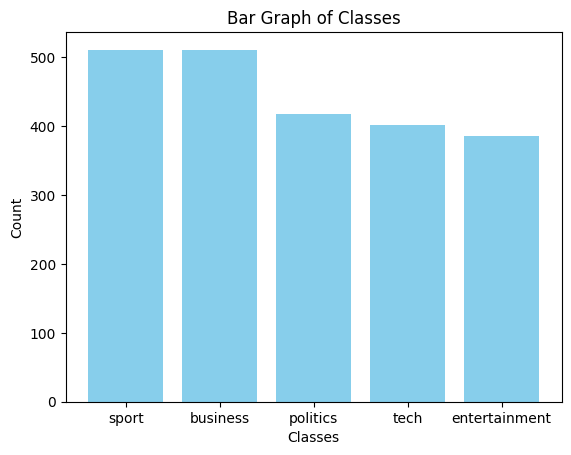

In [58]:
class_counts = df['labels'].value_counts()
plt.bar(class_counts.index, class_counts.values, color='skyblue')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Bar Graph of Classes')

# Show the plot
plt.show()

In [7]:
text=df['text'].values

In [9]:
text[0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sig

In [86]:
df=df.sample(frac=1).reset_index(drop=True)

In [87]:
df.head()

,text,labels
0,Blair buys copies of new Band Aid\n\nPrime Min...,entertainment
1,Stern dropped from radio stations\n\nControver...,entertainment
2,Novartis hits acquisition trail\n\nSwiss drugm...,business
3,South African car demand surges\n\nCar manufac...,business
4,Music mogul Fuller sells company\n\nPop Idol s...,entertainment


In [88]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [89]:
MAX_FEATURES=20000
tokenizer=Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(text)

In [90]:
sequences=tokenizer.texts_to_sequences(text)

In [91]:
len(sequences)

2225

In [92]:
padded_sequences=pad_sequences(sequences,padding='post')

In [93]:
padded_sequences.shape

(2225, 4363)

In [94]:
word2idx=tokenizer.word_index
vocab_size=len(word2idx)
vocab_size

32359

In [95]:
labels=df['labels'].map({"business":0,"entertainment":1,"politics":2,"sport":3,"tech":4}).values

In [96]:
labels

array([1, 1, 0, ..., 3, 1, 0], dtype=int64)

In [97]:
from tensorflow.keras.utils import to_categorical

In [98]:
labels=to_categorical(labels,num_classes=5)

In [99]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [100]:
dataset=tf.data.Dataset.from_tensor_slices((padded_sequences,labels))
dataset=dataset.cache()
dataset=dataset.shuffle(100)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)

In [101]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [102]:
input_size=train.as_numpy_iterator().next()[0].shape[1]

In [103]:
input_size

4363

In [104]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D,Dense,GlobalMaxPooling1D,Embedding,Input,LSTM,Bidirectional

In [113]:
i=Input(shape=(input_size,))
e=Embedding(vocab_size+1,64)(i)
l1=Conv1D(64,kernel_size=3,activation='relu')(e)
# l1=Bidirectional(LSTM(64,activation='tanh'))(e)
# l2=GlobalMaxPooling1D()(l1)
# l3=Conv1D(128,kernel_size=3,activation='relu')(l1)
# l3=Dense(128,activation='relu')(l1)
# l4=Dense(256,activation='relu')(l3)
# l5=Dense(64,activation='relu')(l3)
l4=GlobalMaxPooling1D()(l1)
output=Dense(5,activation='softmax')(l4)
model=Model(i,output)

In [114]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [115]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 4363)]            0         
                                                                 
 embedding_13 (Embedding)    (None, 4363, 64)          2071040   
                                                                 
 conv1d_16 (Conv1D)          (None, 4361, 64)          12352     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_22 (Dense)            (None, 5)                 325       
                                                                 
Total params: 2,083,717
Trainable params: 2,083,717
Non-trainable params: 0
________________________________________________

In [ ]:
history=model.fit(train,epochs=20,validation_data=val)

Epoch 1/20
98/98 [==============================] - 19s 189ms/step - loss: 1.6064 - accuracy: 0.2277 - val_loss: 1.6012 - val_accuracy: 0.2143
Epoch 2/20
98/98 [==============================] - 18s 182ms/step - loss: 1.5328 - accuracy: 0.3323 - val_loss: 1.5855 - val_accuracy: 0.2455
Epoch 3/20
98/98 [==============================] - 18s 183ms/step - loss: 1.4233 - accuracy: 0.5874 - val_loss: 1.5782 - val_accuracy: 0.2589
Epoch 4/20
98/98 [==============================] - 18s 182ms/step - loss: 1.2211 - accuracy: 0.8272 - val_loss: 1.5477 - val_accuracy: 0.3036
Epoch 5/20
98/98 [==============================] - 18s 182ms/step - loss: 0.9004 - accuracy: 0.9254 - val_loss: 1.5236 - val_accuracy: 0.3192
Epoch 6/20
98/98 [==============================] - 18s 182ms/step - loss: 0.5576 - accuracy: 0.9413 - val_loss: 1.5038 - val_accuracy: 0.3214
Epoch 7/20
98/98 [==============================] - 18s 183ms/step - loss: 0.3245 - accuracy: 0.9420 - val_loss: 1.4875 - val_accuracy: 0.3214